In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CUDA version: {torch.version.cuda}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Using device: cuda
CUDA version: 12.1


In [9]:
# === Paths ===
train_dir = os.path.abspath(os.path.join("..", "..", "DATA", "archive", "train"))
valid_dir = os.path.abspath(os.path.join("..", "..", "DATA", "archive", "valid"))
test_dir = os.path.abspath(os.path.join("..", "..", "DATA", "archive", "test"))
# === Constants ===
IMG_SIZE = 224
BATCH_SIZE = 32

In [10]:
# === Load and Preprocess Data ===
train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform
)

valid_dataset = datasets.ImageFolder(
    root=valid_dir,
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transform
)

# === DataLoaders ===
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,  # Adjust based on your system
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


In [13]:
# Get the initial number of images in the train dataset
initial_train_count = len(train_dataset)
print(f"Initial number of images in the train dataset: {initial_train_count}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Load ResNet-50 model without pre-trained weights
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)


# Modify the model for binary classification (empty, occupied)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification (empty, occupied)

# Check if model file exists and load the weights if available
model_path = "best_model.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print(f"Loaded model weights from {model_path}")
else:
    print(f"No model found at {model_path}, training from scratch.")

Initial number of images in the train dataset: 8503


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/ecube/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:37<00:00, 2.74MB/s]


No model found at best_model.pth, training from scratch.


In [14]:
# 1. Device Transfer & Loss/Optimizer
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 2. Training Function
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10):
    best_acc = 0.0
    train_loss, valid_loss, train_acc, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
        train_loss.append(running_loss / total)
        train_acc.append(correct.double() / total)
        
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)
        valid_loss.append(running_loss / total)
        valid_acc.append(correct.double() / total)
        
        if valid_acc[-1] > best_acc:
            best_acc = valid_acc[-1]
            torch.save(model.state_dict(), "best_model.pth")  # Save the best model
        
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {valid_loss[-1]:.4f}, Val Acc: {valid_acc[-1]:.4f}")
    
    return train_loss, train_acc, valid_loss, valid_acc

In [15]:
# Train the model
train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10)

# Get the updated number of images in the train dataset after adding new images
updated_train_count = len(train_dataset)
print(f"Updated number of images in the train dataset: {updated_train_count}")

Epoch 1/10: Train Loss: 0.0826, Train Acc: 0.9740, Val Loss: 0.0319, Val Acc: 0.9901
Epoch 2/10: Train Loss: 0.0329, Train Acc: 0.9912, Val Loss: 0.0145, Val Acc: 0.9967
Epoch 3/10: Train Loss: 0.0195, Train Acc: 0.9949, Val Loss: 0.0101, Val Acc: 0.9975
Epoch 4/10: Train Loss: 0.0139, Train Acc: 0.9960, Val Loss: 0.0142, Val Acc: 0.9950
Epoch 5/10: Train Loss: 0.0117, Train Acc: 0.9972, Val Loss: 0.0079, Val Acc: 0.9963
Epoch 6/10: Train Loss: 0.0075, Train Acc: 0.9973, Val Loss: 0.0032, Val Acc: 0.9992
Epoch 7/10: Train Loss: 0.0050, Train Acc: 0.9984, Val Loss: 0.0050, Val Acc: 0.9988
Epoch 8/10: Train Loss: 0.0068, Train Acc: 0.9982, Val Loss: 0.0837, Val Acc: 0.9835
Epoch 9/10: Train Loss: 0.0213, Train Acc: 0.9948, Val Loss: 0.0111, Val Acc: 0.9975
Epoch 10/10: Train Loss: 0.0035, Train Acc: 0.9989, Val Loss: 0.0047, Val Acc: 0.9992
Updated number of images in the train dataset: 8503


In [16]:
# Plot results
def plot_results(train_loss, train_acc, valid_loss, valid_acc):
    epochs = range(1, len(train_loss) + 1)
    
     # Move data to CPU and convert to numpy arrays for plotting
    train_loss = np.array(train_loss)
    valid_loss = np.array(valid_loss)
 # Ensure the accuracy tensors are moved to CPU before converting to NumPy
    train_acc = np.array([acc.cpu().numpy() for acc in train_acc])  # Move to CPU and convert to NumPy
    valid_acc = np.array([acc.cpu().numpy() for acc in valid_acc])  # Move to CPU and convert to NumPy
    
    plt.figure(figsize=(12, 5))
    
    # Plot Train and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, valid_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Train and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, valid_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()


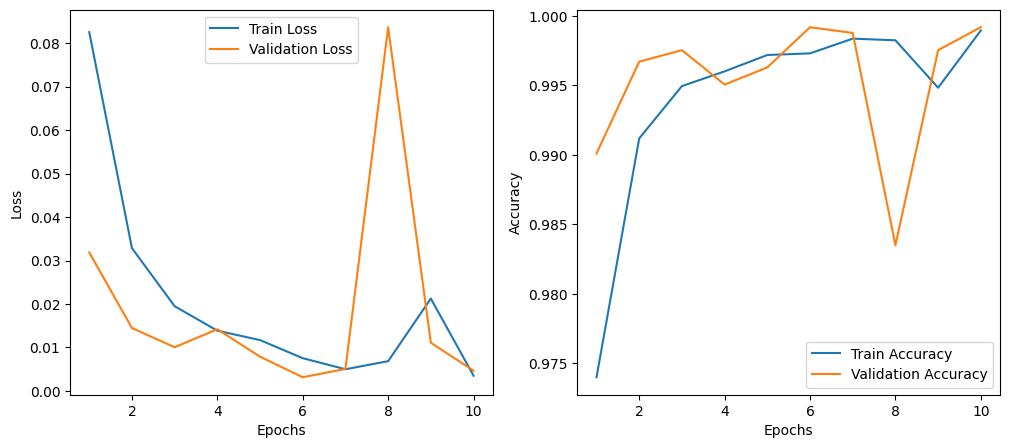

In [17]:
# Call the plotting function
plot_results(train_loss, train_acc, valid_loss, valid_acc)

# ***Define a function to plot the P-R curve*** 

In [37]:
def plot_pr_and_roc(model, dataset, set_name="Validation"):
    """
    Unified function to plot P-R and ROC curves, show classification report and confusion matrix
    for both TensorFlow and PyTorch models.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import (
        precision_recall_curve, roc_curve, roc_auc_score,
        classification_report, confusion_matrix, ConfusionMatrixDisplay
    )
    import torch

    is_pytorch_model = isinstance(model, torch.nn.Module)

    if is_pytorch_model:
        model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        y_true = []
        y_scores = []

        with torch.no_grad():
            for images, labels in dataset:
                images = images.to(device)
                outputs = model(images)
                probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Class 1 (occupied)
                y_scores.extend(probs.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        y_true = np.array(y_true)
        y_scores = np.array(y_scores)

    else:
        # TensorFlow / Keras
        y_true = np.concatenate([y.numpy() for _, y in dataset], axis=0)
        y_scores = model.predict(dataset).squeeze()

    # === Precision–Recall and F1 ===
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = pr_thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    # === ROC Curve and AUC ===
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)

    # === Plot PR and ROC curves ===
    plt.figure(figsize=(14, 6))

    # P-R Curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'{set_name} P-R Curve')
    plt.scatter(recall[best_idx], precision[best_idx], color='red',
                label=f'Best F1={best_f1:.2f} @ Threshold={best_threshold:.2f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({set_name})")
    plt.grid(True)
    plt.legend()

    # ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='orange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({set_name})")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # === Threshold-based Classification ===
    y_pred = (y_scores >= best_threshold).astype(int)

    # === Print Classification Report ===
    print(f"\nClassification Report ({set_name}):")
    print(classification_report(y_true, y_pred, target_names=["Empty", "Occupied"]))

    # === Plot Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Empty", "Occupied"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix ({set_name})")
    plt.show()

    # === Summary ===
    print(f"\nBest Threshold by F1 Score: {best_threshold:.2f} (F1 = {best_f1:.2f})")
    print(f"AUC-ROC Score: {auc_score:.4f}")

    return best_threshold, best_f1


In [38]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_dataset_for_prediction_pytorch(directory, img_size=(224, 224), batch_size=32):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                             std=[0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(root=directory, transform=transform)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataset, loader


In [39]:
VALID_DIR = os.path.abspath(os.path.join("..", "..", "DATA", "archive", "valid"))  
TEST_DIR = os.path.abspath(os.path.join("..", "..", "DATA", "archive", "test"))
_, valid_loader = load_dataset_for_prediction_pytorch(VALID_DIR)
_, test_loader = load_dataset_for_prediction_pytorch(TEST_DIR)

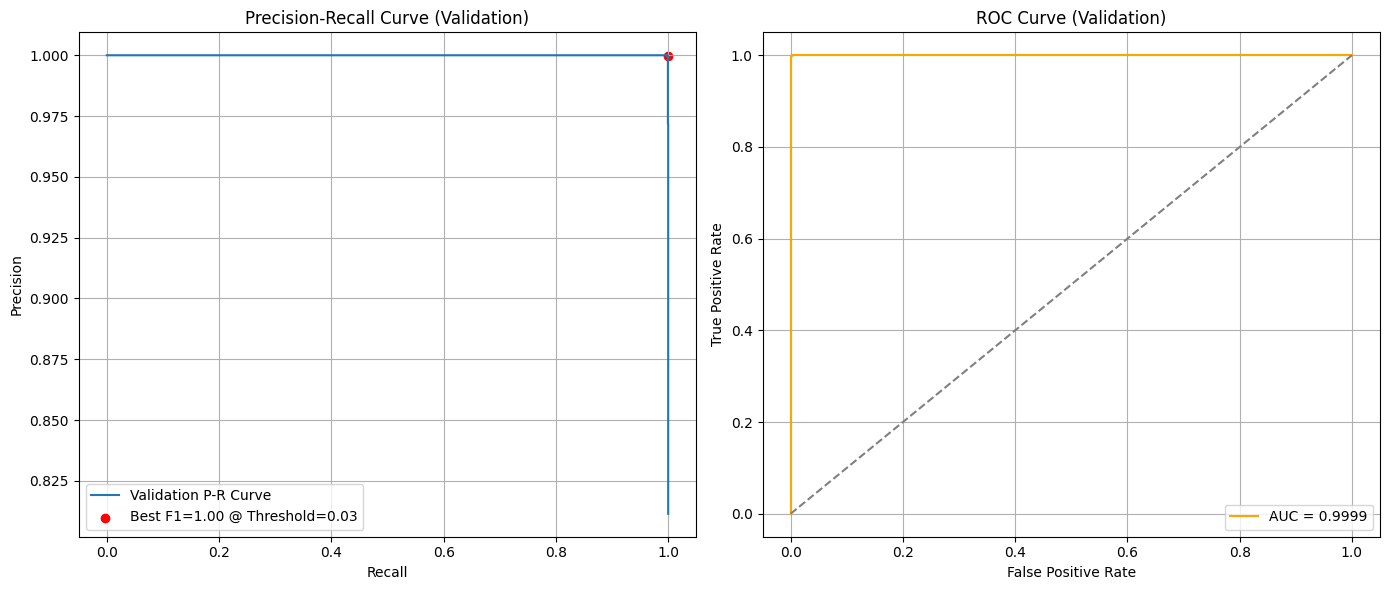


Classification Report (Validation):
              precision    recall  f1-score   support

       Empty       1.00      1.00      1.00       457
    Occupied       1.00      1.00      1.00      1967

    accuracy                           1.00      2424
   macro avg       1.00      1.00      1.00      2424
weighted avg       1.00      1.00      1.00      2424



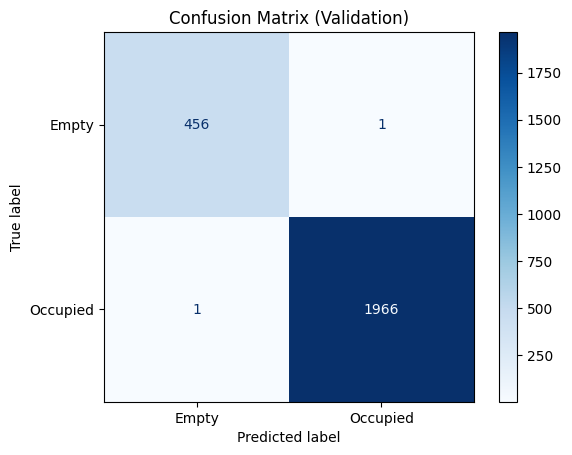


Best Threshold by F1 Score: 0.03 (F1 = 1.00)
AUC-ROC Score: 0.9999


In [40]:
best_threshold, best_f1 = plot_pr_and_roc(model, valid_loader, set_name="Validation")

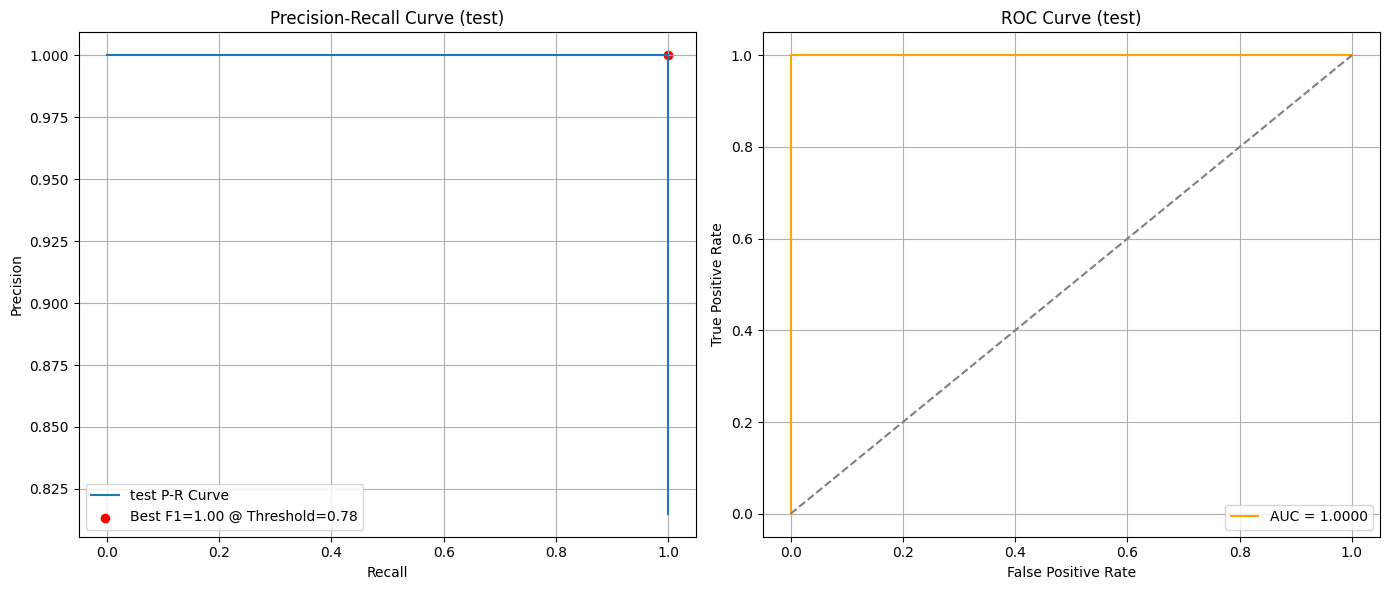


Classification Report (test):
              precision    recall  f1-score   support

       Empty       1.00      1.00      1.00       225
    Occupied       1.00      1.00      1.00       991

    accuracy                           1.00      1216
   macro avg       1.00      1.00      1.00      1216
weighted avg       1.00      1.00      1.00      1216



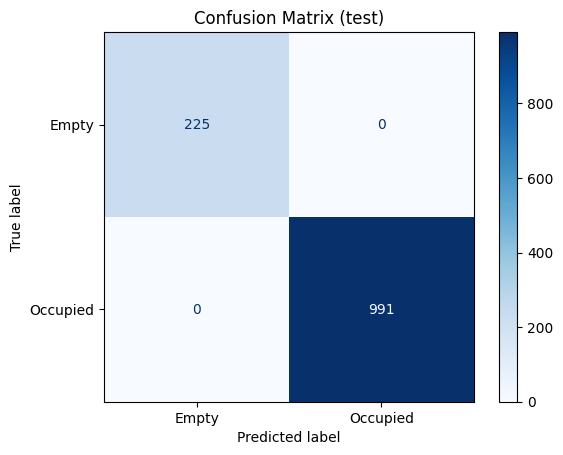


Best Threshold by F1 Score: 0.78 (F1 = 1.00)
AUC-ROC Score: 1.0000


In [41]:
best_threshold, best_f1 = plot_pr_and_roc(model, test_loader, set_name="test")